# TopoCluster Regression Rewrite

Here, we are going to write out our topo-cluster regression notebook. Let's start with charged pions, and see what we can do to understand them.

In [36]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
plotpath = '/home/mswiatlowski/start_tf/caloml-atlas/regression/Plots_rewrite/'
modelpath_c = '/home/mswiatlowski/start_tf/caloml-atlas/classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [2]:
# import pi+- vs. pi0 images

path = '/fast_scratch/atlas_images/v6/'
pp = np.load(path+"piplus_full.npz")

npp = len(pp['EMB1'])

print("Number of pi+ events: {}".format(npp))

Number of pi+ events: 435489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


<Figure size 432x288 with 0 Axes>

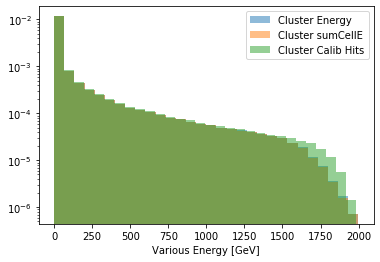

In [4]:
n_bins = 30
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp['clusterE'], bins=n_bins, normed=True, alpha=0.5, label='Cluster Energy')
plt.hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.5, label='Cluster sumCellE')
plt.hist(pp['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='Cluster Calib Hits')
plt.yscale('log')
plt.xlabel('Various Energy [GeV]')
plt.legend()
plt.savefig(plotpath+'/hist_energy.pdf')
plt.show()

## Let's make some response plots now!

<Figure size 432x288 with 0 Axes>

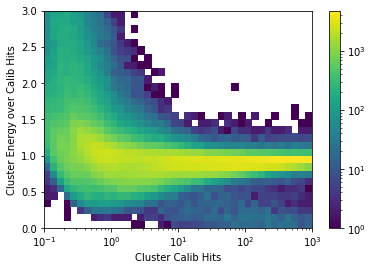

In [41]:
from matplotlib.colors import LogNorm

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
hist2DCalib, x2DCalib, y2DCalib, blah = plt.hist2d(pp['cluster_ENG_CALIB_TOT'],pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],bins=[xbin,ybin],norm=LogNorm())
# plt.hist(p0['clusterECalib']/p0['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='$\pi^0$')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_ratio_pp.pdf')
plt.show()

Above, we can see the dip below 1 at 2-5 GeV, the rise to 1 above that, and the rise way above 1 below that. Interesting!

<Figure size 432x288 with 0 Axes>

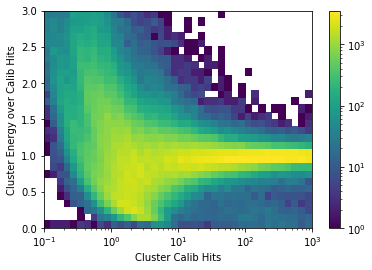

In [7]:
from matplotlib.colors import LogNorm

xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)

n_bins = 30
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT'],pp['clusterECalib']/(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT']),bins=[xbin,ybin],norm=LogNorm())
# plt.hist(p0['clusterECalib']/p0['cluster_ENG_CALIB_TOT'], bins=n_bins, normed=True, alpha=0.5, label='$\pi^0$')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calibfull_vs_ratio_pp.pdf')
plt.show()

Much more of a swoop notice down. But two populations? Potentially related to cases where a shower is fully contained in a cluster or not? Should return to this!

Here, let's see if I can make a profile plot function. 

In [43]:
from scipy.stats import binned_statistic
import scipy.stats as stats

In [52]:
profileX = stats.binned_statistic(pp['cluster_ENG_CALIB_TOT'],
                                        pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                                        bins=xbin,statistic='mean').statistic

In [53]:
profileXMed = stats.binned_statistic(pp['cluster_ENG_CALIB_TOT'],
                                        pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],
                                        bins=xbin,statistic='median').statistic

In [62]:
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

<Figure size 432x288 with 0 Axes>

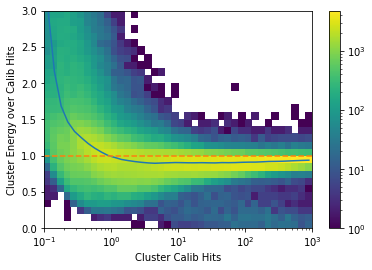

In [66]:
xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.1)
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['cluster_ENG_CALIB_TOT'],pp['clusterE']/pp['cluster_ENG_CALIB_TOT'],bins=[xbin,ybin],norm=LogNorm())
plt.plot(xcenter, profileXMed)
plt.plot([0.1,1000],[1,1],linestyle='--')
plt.xscale('log')
plt.ylim(0,3)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over Calib Hits')
plt.colorbar()
# plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_ratio_pp_profile.pdf')
plt.show()

This is what we wanted! Nice. Can see the shapes that we expect. Let's wrap this all into a function.

In [83]:
def responsePlot(x, y, name, statistic='median'):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    profileXMed = stats.binned_statistic(x, y, bins=xbin,statistic=statistic).statistic

    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x,y,bins=[xbin,ybin],norm=LogNorm())
    plt.plot([0.1,1000],[1,1],linestyle='--')
    plt.plot(xcenter, profileXMed)
    plt.xscale('log')
    plt.ylim(0,3)
    plt.xlabel('Cluster Calib Hits')
    plt.ylabel('Cluster Energy over Calib Hits')
    plt.colorbar()
    # plt.legend()
    plt.savefig(plotpath+'/'+name+'.pdf')
    plt.show()

<Figure size 432x288 with 0 Axes>

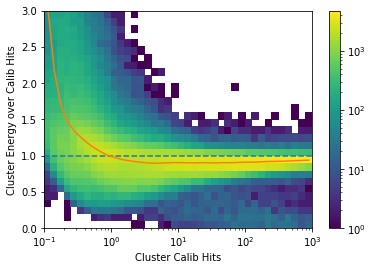

In [70]:
responsePlot(pp['cluster_ENG_CALIB_TOT'], pp['clusterE']/pp['cluster_ENG_CALIB_TOT'], 'hist_2D_calib_vs_ratio_pp_profile')

Let's see if I can get the profile with the other 2D plot we had seen before:

<Figure size 432x288 with 0 Axes>

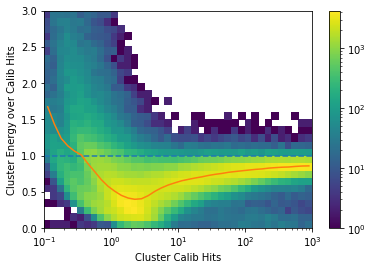

In [71]:
responsePlot(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT'], 
                pp['clusterE']/(pp['cluster_ENG_CALIB_TOT']+pp['cluster_ENG_CALIB_OUT_T']+pp['cluster_ENG_CALIB_DEAD_TOT']),                       'hist_2D_calibfull_vs_ratio_pp_profile')

We see it's way lower! Could it be that when the energy / true is very high in the previous plot, it's because "true" is missing energy outside the cluster or in the dead material? But the cluster itself shoudln't be picking that up. Weird.

## Let's implement the basic regression again!

In [72]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2","/gpu:3"])
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:1
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:2
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:3
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:4
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:5
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:6
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:7
INFO:tensorflow:Device is available but not used by distribute strategy: /device:GPU:1
INFO:te

In [73]:

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
    regressor = Sequential()
    regressor.add(Dense(units=24, input_dim=1, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=24, kernel_initializer='normal', activation='relu'))
    regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
    opt = Adam(lr=1e-4, decay=1e-6)
    regressor.compile(optimizer=opt, loss='mse')

    return regressor

Using TensorFlow backend.


In [74]:
from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=baseline_model, batch_size=200*ngpu, epochs=50, verbose=1)
print(baseline_model().summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
energy_pp = pp['clusterE']
calib_hits_pp = pp['cluster_ENG_CALIB_TOT']

energy_pp_l = np.log(energy_pp)
calib_hits_pp_l = np.log(calib_hits_pp)

In [76]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_epp = StandardScaler()
scalar_cal = StandardScaler()
# fit and transform in one step
standardized_energy_l = scaler_epp.fit_transform(energy_pp_l.reshape(-1,1))
standardized_calib_l  = scalar_cal.fit_transform(calib_hits_pp_l.reshape(-1,1))
# inverse transform
#inverse = scaler_epp.inverse_transform(standardized)

In [77]:
history_baseline = regressor.fit([standardized_energy_l], standardized_calib_l)

Epoch 1/50
435489/435489 [==============================] - 10s 23us/sample - loss: 0.2904
Epoch 2/50
435489/435489 [==============================] - 8s 17us/sample - loss: 0.0381
Epoch 3/50
435489/435489 [==============================] - 8s 17us/sample - loss: 0.0365
Epoch 4/50
435489/435489 [==============================] - 7s 17us/sample - loss: 0.0360
Epoch 5/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0357
Epoch 6/50
435489/435489 [==============================] - 8s 17us/sample - loss: 0.0356
Epoch 7/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0356
Epoch 8/50
435489/435489 [==============================] - 8s 18us/sample - loss: 0.0355
Epoch 9/50
435489/435489 [==============================] - 8s 17us/sample - loss: 0.0355
Epoch 10/50
435489/435489 [==============================] - 8s 17us/sample - loss: 0.0355
Epoch 11/50
435489/435489 [==============================] - 7s 17us/sample - loss: 0.0355
Epoch 1

In [78]:
predict_base_pp = np.exp(scalar_cal.inverse_transform(regressor.predict([standardized_energy_l])))

435489/435489 [==============================] - 2s 4us/sample


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

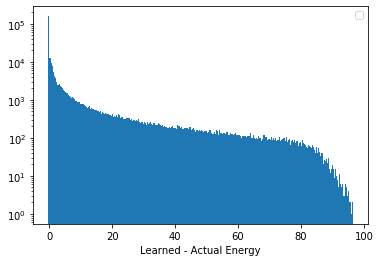

In [79]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(predict_base_pp-energy_pp,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

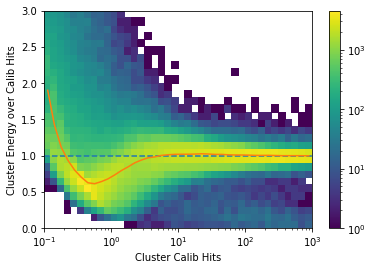

In [85]:
responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_pp/pp['cluster_ENG_CALIB_TOT'],
                 'hist_2D_calib_vs_baselineregratio_pp_profile',
                 'median')

Looking cool! One question: are we learning the mean, or median? We seem to be lowering things too much... to be understood!

<Figure size 432x288 with 0 Axes>

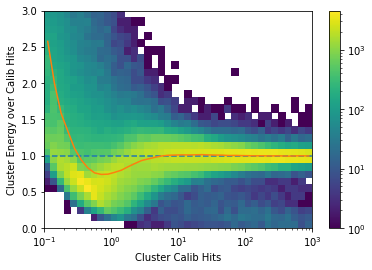

In [86]:
responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_pp/pp['cluster_ENG_CALIB_TOT'],
                 'hist_2D_calib_vs_baselineregratio_pp_profile_mean',
                 'mean')

Weird! Worse at low, but the bump is less affected. High is fine.